In [38]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from functools import reduce
from statistics import mean

In [39]:
def extractCosts(jsonfiles):
    costs = {}
    for f in jsonfiles:
        instance = f['config']['instance']
        costs[instance] = []
        for expl in f['results']['expl_seq']:
            costs[instance].append(expl['cost'])
        
    return costs

In [40]:
def plotCosts(ousCosts, musCosts, figsize, coeff_thick = 8):
#     plt.figure(figsize=figsize)
 
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        # minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        x+= x1
        y += y1
    
    d = {}
    for xi,yi in zip(x, y):
        if (xi, yi) in d:
            d[(xi, yi)] += coeff_thick
        else:
            d[(xi, yi)] = coeff_thick

    xplot = [] 
    yplot = []
    splot = []  
    for ((xi, yi), si) in d.items():
        xplot.append(xi)
        yplot.append(yi)
        splot.append(si)
    plt.scatter(xplot, yplot, s=splot)
#         # allCosts.append((x1, y1))
    # Plot formatting
    plt.plot(range(0, 400, 1) , range(0, 400, 1), linestyle='--')
    # plt.xlim((0, 50))
    plt.xlabel('OUS Explanation cost')
    plt.ylabel('MUS Explanation cost')
#     plt.title(instance + " - " + col)
#     plt.title("Comparison OUS/MUS Explanation cost", fontsize=20)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiemnt5_qualitative_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.png", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.jpg", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.pdf", bbox_inches='tight')
    plt.show()


In [41]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        
        json_dict.update({'fname':f_path.name})
        
    return json_dict

In [42]:
def plot_instance_post(df, instance, col):
    
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]

    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,15))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20, loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((0, 2000))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
    plt.title("Title")
    
    plt.show()


In [43]:
import matplotlib.pyplot as plt

# Origin problem
def plot_instance_col(df, instance, col):
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]
    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,30))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20)
    # plt.xlim((0, 50))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
#     plt.title(instance + " - " + col)
    plt.title("Title")
    plt.savefig('/home/crunchmonster/Desktop/figs/'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.show()


In [44]:
def groupByConfWithReduce(df, selectedConfigFilters, title, fact='cumul-ous'):
    allconfigKeys = ['preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv']
    groupKeys = [key for key in allconfigKeys if key not in selectedConfigFilters]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    # display(dfgrouped)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))

    mapping = {
        'preseeding':'pre!',
        'sat-polarity': 'sat-pol',
        'sat-polarity-initial': 'sat-pol-ini',
        'postpone_opt': 'post',
        'postpone_opt_incr': 'p_incr',
        'postpone_opt_greedy': 'p_greedy',
        'grow': 'grow',
        'grow_sat': 'g_sat',
        'grow_subset_maximal': 'g_subset',
        'grow_maxsat': 'g_maxsat',
        'maxsat_polarities': '_maxsatpols_',
        'grow_maxsat_full_pos': 'max_full_pos',
        'grow_maxsat_full_inv': 'max_full_inv',
        'grow_maxsat_full_unif': 'max_full_unif',
        'grow_maxsat_initial_pos': 'max_init_pos',
        'grow_maxsat_initial_inv': 'max_ini_inv',
        'grow_maxsat_initial_unif': 'max_ini_pos',
        'grow_maxsat_actual_pos': 'max_actual_pos',
        'grow_maxsat_actual_unif': 'max_actual_unif',
        'grow_maxsat_actual_inv': 'max_actual_inv',
    }
    dfgrouped['config'] = dfgrouped.apply(
        lambda x: reduce(lambda a, b: a + (mapping[b]+'_' if x[b] else ''), [field for field in groupKeys if field not in [fact] and x[field]] , ""),
        axis = 1
    )
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    dfgrouped.sort_values(by ='len', ascending=False)
    # display(dfgrouped[['x','cumul-ous']])
    mStyles = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    mStyles = mStyles * 10
    plt.figure(figsize=(80,40))
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=marker )
    plt.legend(fontsize=20)
    plt.xlabel('Explanation steps ordered', fontsize=20)
    plt.xlim((0, 5000))
    plt.ylabel('Time!', fontsize=20)
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiment4'+ datetime.now().strftime("%Y%m%d%H%M%S%f.pdf"), optimize=True, bbox_inches='tight')
    dfgrouped.to_json('/home/crunchmonster/Desktop/json/experiment4'+ '_' + title+ '_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.json"))
    dfgrouped.to_csv('/home/crunchmonster/Desktop/json/experiment4'+ '_' + title+ '_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.csv"))
    plt.show()


In [45]:
def jsonFilesToPandasDF(json_files):
    timeoutTime = 7200
    pd_dict = {
        # running parameters
        'timedout':[],
        'config':[],
        'cumul-ous': [],
        'cumul-sat':[],
        'cumul-post':[],
        'cumul-opt':[],
        'cumul-HS': [],
        'cumul-HS-all': [],
        'totTime': [],
        'timeToFirst': [],
        'First-Tot': [],
        'fname':[],
        'created':[],
        'maxsat_polarities':[],
        'disableConstrained':[]
    }

    config_mapping = {
            'preseeding': 'pre',
            'preseeding-grow': 'pre-grow',
            'sat-polarity':'satpol',
            'sat-polarity-initial': 'satpol-ini',
            'postpone_opt_incr':'incr',
            'postpone_opt_greedy':'greedy',
            'grow_subset_maximal':'subset-max',
            'grow_sat':'grow_sat',
            'grow_maxsat_full_unif':"MaxSat-A-unif",
            'grow_maxsat_full_pos':"MaxSat-A-pos",
            'grow_maxsat_full_inv': "MaxSat-A-inv",
            'grow_maxsat_initial_pos': "MaxSat-I0-pos", 
            'grow_maxsat_initial_inv':  "MaxSat-I0-inv", 
            'grow_maxsat_initial_unif': "MaxSat-I0-unif", 
            'grow_maxsat_actual_pos':  "MaxSat-Icur-pos",  
            'grow_maxsat_actual_unif': "MaxSat-Icur-unif", 
            'grow_maxsat_actual_inv': "MaxSat-Icur-inv",
            'maxsat_polarities': "maxsat_polarities"
    }
    

    for f_json in json_files:
        for k, v in f_json['config'].items():
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if k == 'timeout':
                pd_dict['timedout'].append(v)
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        if 'maxsat_polarities' not in f_json['config']:
            pd_dict["maxsat_polarities"].append(False)
        if 'disableConstrained' not in f_json['config']:
            pd_dict['disableConstrained'].append(False)
        pd_dict['fname'].append(f_json['fname'])
        
        pd_dict['created'].append(datetime.strptime(f_json['fname'].split('_')[1].replace('.json',''), '%Y%m%d%H%M%S%f'))

        add_configs = [f_json['config']['instance'] if f_json['config']['instance'] != 'origin-problem' else 'puzzle']

        for k,v in f_json['config'].items():
            if v == True and k in config_mapping:
                add_configs.append(config_mapping[k])

        if pd_dict['timedout']:
            pd_dict['totTime'].append(timeoutTime)
                
        pd_dict['config'].append('_'.join(add_configs))
        if 'OUS-time' in f_json['results']: 
            pd_dict['cumul-ous'].append( 
                ([
                    sum(f_json['results']['OUS-time'][:i+1]) 
                    for i in range(len(f_json['results']['OUS-time'])) ] + []) if not pd_dict['timedout'] else ([sum(f_json['results']['OUS-time'][:i+1]) for i in range(len(f_json['results']['OUS-time'])) ] + [timeoutTime])
            )
        if 'OUS-time' in f_json['results']: 
            pd_dict['timeToFirst'].append(f_json['results']['OUS-time'][1])
            pd_dict['First-Tot'].append(f"{round(f_json['results']['OUS-time'][1], 2)} - [{f_json['results']['#expl']}] {'' if pd_dict['timedout'] else pd_dict['totTime'][-1]}" )
        else:
            pd_dict['timeToFirst'].append('-')
            pd_dict['First-Tot'].append('-')
        if 'HS-opt-time' in f_json['results']: 
            pd_dict['cumul-opt'].append( [sum(f_json['results']['HS-opt-time'][:i+1]) for i in range(len(f_json['results']['HS-opt-time'])) ])
        else:
            pd_dict['cumul-opt'].append('-')
        if 'HS-postpone-time' in f_json['results']: 
            pd_dict['cumul-post'].append( [sum(f_json['results']['HS-postpone-time'][:i+1]) for i in range(len(f_json['results']['HS-postpone-time'])) ])
        else:
            pd_dict['cumul-post'].append('-')
        if 'SAT-time' in f_json['results']: 
            pd_dict['cumul-sat'].append( [sum(f_json['results']['SAT-time'][:i+1]) for i in range(len(f_json['results']['SAT-time'])) ])
        else:
            pd_dict['cumul-sat'].append('-')
        if 'HS' in f_json['results']: 
            pd_dict['cumul-HS'].append( [sum(f_json['results']['HS'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
            pd_dict['cumul-HS-all'].append( [sum(f_json['results']['HS'][:i+1])+sum(f_json['results']['HS_incr'][:i+1])+sum(f_json['results']['HS_greedy'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
        else:
            pd_dict['cumul-HS-all'].append('-')
            pd_dict['cumul-HS'].append('-')

    return pd_dict

In [46]:
def musTimes(jsonMUS, instances):
    results = {k: 7200 for k in instances}
    for musTime in jsonMUS:
        results[musTime['config']['instance']] = round(sum(musTime['results']['MUS-time']))
    return results

In [47]:
def jsonToBest(jsonFiles, instances):
    results = {k: 7200 for k in instances}
    configs = {k:'' for k in instances}
    for f in jsonFiles:
        if f['config']['preseeding'] == True:
            continue
        instance = f['config']['instance']
        totTime =  f["config"]["timeout"] if f['results']["timeout"] else sum(f['results']["OUS-time"]) 
        if instance not in results or totTime < results[instance] :
            results[instance] = round(totTime)
            configs[instance] = f['config']
    return results, configs



In [48]:
def greedyJsonToBest(jsonFiles, instances):
    resultsIncr = {k: 7200 for k in instances}
    resultsNonIncr = {k: 7200 for k in instances}
    configsIncr = {k: None for k in instances}
    configsNonIncr = {k: None for k in instances}
    for f in jsonFiles:
        if f['results']['timeout'] == True:
            continue
        instance = f['config']['instance']

        totTime = f['results']['totTime'] if 'totTime' in f['results'] else sum(sum(subl) for subl in f['results']["OUS-time"])
        if f['config']['reuse_SSes']:
            if instance not in resultsIncr or totTime <= resultsIncr[instance]:
                resultsIncr[instance] = round(totTime)
                configsIncr[instance] = f['config']
        else:
            if instance not in resultsNonIncr or totTime <= resultsNonIncr[instance]:
                resultsNonIncr[instance] = round(totTime)
                configsNonIncr[instance] = f['config']

    return resultsIncr, resultsNonIncr, configsIncr, configsNonIncr

In [49]:
def fillDictResults(dictResults, results, Name):
    for k,v in results.items():
        pos = dictResults['puzzles'].index(k)
        dictResults[Name][pos] = v

In [50]:
def bestPreseedingOffOn(jsonFiles, instances):
    bestPreseedingOff = {k: 7200 for k in instances}
    bestPreseedingOn = {k: 7200 for k in instances}
    for f in jsonFiles:
        instance = f['config']['instance']
        totTime =  f["config"]["timeout"] if f['results']["timeout"] else sum(f['results']["OUS-time"]) 
        preseeding = f['config']['preseeding']
        if preseeding:
            if instance not in bestPreseedingOn or totTime < bestPreseedingOn[instance] :
                bestPreseedingOn[instance] = round(totTime)
        else:
            if instance not in bestPreseedingOff or totTime < bestPreseedingOff[instance] :
                bestPreseedingOff[instance] = round(totTime)

    return bestPreseedingOff, bestPreseedingOn


In [51]:
def cactusGrouped(df,title="cumul-ous", fact='cumul-ous', groupKeys=[]):
    import random
    if len(groupKeys) == 0:
        groupKeys = ["grow_subset_maximal","grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))
    mapping = {
        'grow_maxsat_full_pos': 'full+pos',
        'grow_maxsat_full_inv': 'full+inv',
        'grow_maxsat_full_unif': 'full+unif',
        'grow_maxsat_actual_pos': 'actual+pos',
        'grow_maxsat_actual_unif': 'actual+unif',
        'grow_maxsat_actual_inv': 'actual+inv',
        'grow_subset_maximal':'subset-max'
    }
    
    dfgrouped['config'] = dfgrouped.apply(
        lambda x: reduce(lambda a, b: a + (mapping[b] if x[b] else ''), [field for field in groupKeys if field not in [fact] and x[field]] , ""),
        axis = 1
    )
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    dfgrouped.sort_values(by ='len', ascending=False)
    display(dfgrouped[['x','cumul-ous']])
#     plt.figure(figsize=(20,10))
    mStyles = [".",",","v","^","<",">","*","h","H","+","x"]
    random.shuffle(mStyles)
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=marker)
    plt.legend()
    plt.xlabel('Explanation steps')
    plt.xlim((0, 1600))
    plt.ylabel('CPU time (s)')
#     plt.title(title, fontsize=12)
    plt.grid(True)
    plt.show()

In [52]:
def jsonFilesToExtendedDf(jsonFiles, greedy=False, OUS=True):
    pd_dict = {}
    for f_json in jsonFiles:
        if OUS:
            if greedy:
                soutime = []
                for subl in f_json['results']["OUS-time"]:
                    soutime.append([t for t in subl if t > 0])
            else:
                f_json['results']["OUS-time"] = [t for t in f_json['results']["OUS-time"] if t > 0]
        for k, v in f_json['config'].items():
            if k == 'timeout' or k == 'disableConstrained':
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if 'totTime' == k:
                continue

            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
            
    # making sure all values are of same lengt
    notgood = False
    for k, v in pd_dict.items():
        if OUS:
            if len(pd_dict['grow']) != len(v):
                notgood = True
    if notgood:
        raise "k,v error"
    df = pd.DataFrame(pd_dict)
    
    if OUS:
        if greedy:
            df['totTime'] = df.apply(lambda row: sum(sum(subl) for subl in row["OUS-time"]), axis=1)
        else:
            df['totTime'] = df.apply(lambda row: sum(row["OUS-time"]), axis=1)
    else:
        df['totTime'] = df.apply(lambda row: sum(row["MUS-time"]), axis=1)
        
    df['totTime'] = df.apply(lambda row: 7200 if row["timeout"] else row['totTime'], axis=1)
    if OUS:
        if greedy:
            df['cumul-ous'] = df.apply(lambda row: [sum(sum(subl) for subl in row["OUS-time"][:i]) for i in range(1, len(row["OUS-time"])+1)] , axis=1)
        else:
            df['cumul-ous'] = df.apply(lambda row: [sum(row["OUS-time"][:i]) for i in range(1, len(row["OUS-time"])+1)] , axis=1)
        df['cumul-ous'] = df.apply(lambda row: row["cumul-ous"]+[7200] if row["timeout"] else row["cumul-ous"], axis=1)
    else:
        df['cumul-ous' ] = df.apply(lambda row: [sum(row["MUS-time"][:i]) for i in range(1, len(row["MUS-time"])+1)] , axis=1)
    return df

def folderToDf(folder, greedy=False, OUS=True):
    files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
    df = jsonFilesToExtendedDf(files, greedy, OUS)
    return df

In [53]:
def cactusGrouped2(df,title="cumul-ous", fact='cumul-ous', groupKeys=[], outside=False, filename="blabla",xlim=None, legendpos='upper left'):
    import random
    if len(groupKeys) == 0:
        groupKeys = ["grow_subset_maximal","grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))
   
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    dfgrouped.sort_values(by ='len', ascending=False)
    display(dfgrouped[['x','cumul-ous']])
#     plt.figure(figsize=(20,10))
    mStyles = ["1","+","x"] * 4
    random.shuffle(mStyles)
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=",")

    if outside:
        plt.legend(bbox_to_anchor=(1,1), loc=legendpos)
    else:
        plt.legend(loc=legendpos)
    plt.xlabel('log #Explanation steps')
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylabel('Cumulative CPU time (s)')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

In [54]:
import math
def round_down(n, z):
    decimals = -1
    multiplier = 10 ** decimals
    return round(math.floor(n * multiplier) / multiplier)



def round_50(n, i=50):
    rounded = (n // i) * i
    return rounded


def heatMapCosts(ousCosts, musCosts, coeff_thick=1):
#     plt.figure(figsize=figsize)
 
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        # minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        x+= x1
        y += y1
    
    d = {}
    for xi,yi in zip(x, y):
        if (xi, yi) in d:
            d[(xi, yi)] += coeff_thick
        else:
            d[(xi, yi)] = coeff_thick

    rounding = round_50
    num = 30
    xmin, xmax = min(x+y), max(x+y)
    all_vals = list(range(rounding(xmin, num), rounding(xmax+num, num), num))
#     all_vals = list(set(rounding(l,num) for l in x + y))
    all_vals.sort()
    all_valsreversed = list(all_vals)
    all_valsreversed.sort(reverse=True)
    
    matx = [[0] * len(all_vals) for i in all_vals]
    
    
    for ((xi, yi), si) in d.items():
        
        xpos = all_vals.index(rounding(xi, num))
        ypos = all_valsreversed.index(rounding(yi, num))
        matx[ypos][xpos] = si
        
#     fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(matx, cmap='Greys', interpolation='nearest')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(all_vals)))
    ax.set_yticks(np.arange(len(all_vals)))
    # ... and label them with the respective list entries.
    xticksLabels = [str(val) if idx % 2 == 0 else "" for idx, val in  enumerate(all_vals) ]
    ax.set_xticklabels(xticksLabels)
    yticksLabels = list(xticksLabels)
    yticksLabels.reverse()
    ax.set_yticklabels(yticksLabels)
    
    ax.plot(np.arange(len(all_vals)),range(len(all_vals)-1, -1, -1),linestyle='--')
    fig.tight_layout()
    # plt.xlim((0, 50))
    plt.xlabel('OUS Explanation cost')
    plt.ylabel('MUS Explanation cost')
    vals= [60, 120, 200, 260, 380]
    valsreversed = [60, 120, 200, 260, 380]
    valsreversed.reverse()

    plt.show()



# Experiment 5

Analyzing the qualitative improvement over the explanation sequence.

**Fixed:**
- Optimal explanation sequence generated and fixed.
- For every optimal explanation step, compute the explanation with MUS.
- Plot the difference 

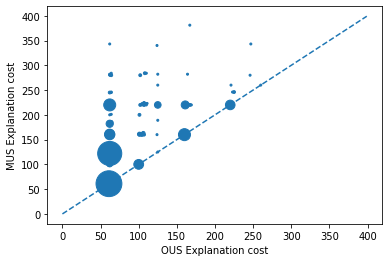

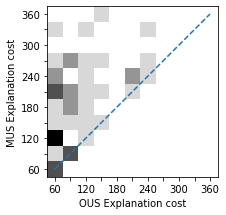

In [55]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5_qualitative/2021011617/'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
mus_json_files = [f for f in json_files if 'MUS-time' in f['results'].keys()]
ous_json_files = [f for f in json_files if f not in mus_json_files]
musCosts = extractCosts(mus_json_files)
ousCosts = extractCosts(ous_json_files)

plotCosts(ousCosts, musCosts, (5, 4), coeff_thick=4)
heatMapCosts(ousCosts, musCosts, coeff_thick=4)

# Experiment6

For every puzzle get the explanation sequence fastest result

folder = 

# RQ4 - Which domain-specific grow methods perform best?

/home/crunchmonster/.local/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x,cumul-ous
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003141641616821289, 3.6233270168304443, 12...."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.12140989303588867, 2.639958143234253, 9.336..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5283381938934326, 0.5345687866210938, 1.457..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.007723808288574219, 1.735947847366333, 2.32..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003930091857910156, 1.8328213691711426, 2.6..."
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0036039352416992188, 8.153310537338257, 11...."
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0033614635467529297, 52.605934858322144, 54..."
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003731966018676758, 7.845459222793579, 11.9..."


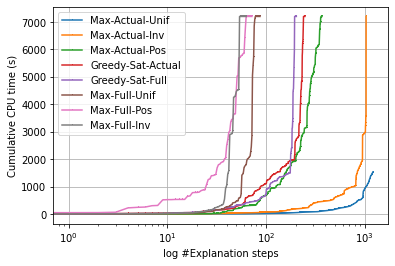

In [56]:
# analyzing grow methods
base= "/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_subset_actual/"
subsetcOUSIncr =   base + "cOUSIncr"
subsetcOUSNonIncr = base + "cOUSNonIncr"
subsetgreedyIncr = base + "greedyIncr"
subsetgreedyNonIncr = base + "greedyNonIncr"

dfsubsetcOUSIncr = folderToDf(subsetcOUSIncr)
dfsubsetcOUSNonIncr = folderToDf(subsetcOUSNonIncr)
dfsubsetgreedyIncr = folderToDf(subsetgreedyIncr, greedy=True)
dfsubsetgreedyNonIncr = folderToDf(subsetgreedyNonIncr, greedy=True)

dfsubsetcOUSIncr["config"] = dfsubsetcOUSIncr.apply(lambda x: "cOUS+I", axis = 1)
dfsubsetcOUSNonIncr["config"] = dfsubsetcOUSNonIncr.apply(lambda x: "cOUS", axis = 1)
dfsubsetgreedyIncr["config"] = dfsubsetgreedyIncr.apply(lambda x: "OUS+I", axis = 1)
dfsubsetgreedyNonIncr["config"] = dfsubsetgreedyNonIncr.apply(lambda x: "OUS", axis = 1)

# dfAllSubsets = dfsubsetcOUSIncr.append([dfsubsetcOUSNonIncr, dfsubsetgreedyIncr, dfsubsetgreedyNonIncr])
dfExp4grows = folderToDf("/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4")
dfexp4growFiltered = dfExp4grows[    
    (dfExp4grows["postpone_opt"] == False)& 
    ((
        (dfExp4grows["grow_maxsat"] == True) & 
        (
            (dfExp4grows['grow_maxsat_actual_pos'] == True) | 
            (dfExp4grows['grow_maxsat_actual_unif'] == True) |
            (dfExp4grows['grow_maxsat_actual_inv'] == True) |
            (dfExp4grows['grow_maxsat_full_pos'] == True) |
            (dfExp4grows['grow_maxsat_full_inv'] == True) |
            (dfExp4grows['grow_maxsat_full_unif'] == True)
        )) | (dfExp4grows["grow_subset_maximal"] == True)
    )]
mappingGrows = {
    'grow_maxsat_actual_pos': 'Max-Actual-Pos',
    'grow_maxsat_actual_unif': 'Max-Actual-Unif',
    'grow_maxsat_actual_inv': 'Max-Actual-Inv',
    'grow_maxsat_full_pos': 'Max-Full-Pos',
    'grow_maxsat_full_inv': 'Max-Full-Inv',
    'grow_maxsat_full_unif': 'Max-Full-Unif',
    "grow_subset_maximal": 'Greedy-Sat-Full',
}
cols = {dfExp4grows.columns.get_loc(k): v for k, v in mappingGrows.items()}

dfexp4growFiltered["config"] = dfexp4growFiltered.apply(lambda row: [cols[i] for i, k in  enumerate(row) if i in cols and k][0], axis=1)

selectedConfigFilters= ["instance","grow_subset_maximal", "grow_maxsat", "grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]

dfexp4growFiltered = dfexp4growFiltered.loc[dfexp4growFiltered.groupby(by=selectedConfigFilters)["totTime"].idxmin()]
dfexp4subsetActual = pd.DataFrame(dfsubsetcOUSIncr)
dfexp4subsetActual["config"] = dfexp4subsetActual.apply(lambda x: "Greedy-Sat-Actual", axis = 1)
dfexp4allgrows = dfexp4growFiltered.append(dfexp4subsetActual)

cactusGrouped2(dfexp4allgrows, fact='cumul-ous', groupKeys=["config"], filename="loggrowWithSubsetmax", legendpos='upper left')

In [57]:
# processing files

musFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5/2021011809/'
dfMUS = folderToDf(musFolder, OUS=False)
dfMUS['config'] = dfMUS.apply(lambda x: "MUS", axis=1)

cOUSnonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
dfcOUSnonIncr = folderToDf(cOUSnonIncrFolder)
dfcOUSnonIncrFiltered = dfcOUSnonIncr[
    (dfcOUSnonIncr["postpone_opt"] == False)&
    (dfcOUSnonIncr["grow_maxsat"] == True) & 
    (dfcOUSnonIncr['grow_maxsat_actual_unif'] == True)]

cOUSIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
dfcOUSIncr = folderToDf(cOUSIncrFolder)
dfcOUSIncrFiltered = dfcOUSIncr[
    (dfcOUSIncr["postpone_opt"] == False)&
    (dfcOUSIncr["grow_maxsat"] == True) & 
    (dfcOUSIncr['grow_maxsat_actual_unif'] == True)]

greedyFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_greedy/20210117/'
dfGreedy = folderToDf(greedyFolder, True)
dfGreedyFiltered = dfGreedy[
    (dfGreedy["postpone_opt"] == False)&
    (dfGreedy["grow_maxsat"] == True) & 
    (dfGreedy['grow_maxsat_actual_unif'] == True)]

In [58]:
# selected config filters
selectedcOUSConfigFilters= ["instance","grow_maxsat_actual_unif"]
selectedColumns = ["instance", "cumul-ous", "totTime"]

dfcOUSnonIncrFiltered = dfcOUSnonIncrFiltered.loc[dfcOUSnonIncrFiltered.groupby(by=selectedcOUSConfigFilters)["totTime"].idxmin()]
dfcOUSnonIncrFiltered = dfcOUSnonIncrFiltered[selectedColumns]
dfcOUSnonIncrFiltered['config'] = dfcOUSnonIncrFiltered.apply(lambda x: "OCUS", axis=1)

dfcOUSIncrFiltered = dfcOUSIncrFiltered.loc[dfcOUSIncrFiltered.groupby(by=selectedcOUSConfigFilters)["totTime"].idxmin()]
dfcOUSIncrFiltered = dfcOUSIncrFiltered[selectedColumns]
dfcOUSIncrFiltered['config'] = dfcOUSIncrFiltered.apply(lambda x: "OCUS+I", axis=1)

selectedgreedyConfigFilters= ["reuse_SSes", "instance", "grow_maxsat_actual_unif"]
dfGreedyFiltered = dfGreedyFiltered.loc[dfGreedyFiltered.groupby(by=selectedgreedyConfigFilters)["totTime"].idxmin()]

dfGreedyFilteredNonIncr = dfGreedyFiltered[dfGreedyFiltered["reuse_SSes"] == False][selectedColumns]
dfGreedyFilteredIncr = dfGreedyFiltered[dfGreedyFiltered["reuse_SSes"] == True][selectedColumns]
dfGreedyFilteredNonIncr['config'] = dfGreedyFilteredNonIncr.apply(lambda x: "OUS", axis=1)
dfGreedyFilteredIncr['config'] = dfGreedyFilteredIncr.apply(lambda x: "OUS+I", axis=1)

dfAllConfigs = dfcOUSnonIncrFiltered.append([dfcOUSIncrFiltered, dfGreedyFilteredNonIncr, dfGreedyFilteredIncr, dfMUS])

,x,cumul-ous
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[9.509942293167114, 9.591385126113892, 10.6479..."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.008920907974243164, 0.5896859169006348, 1.3..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003930091857910156, 1.8328213691711426, 2.6..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[45.562358379364014, 66.95311498641968, 76.621..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[35.1514208316803, 51.169804096221924, 57.2781..."


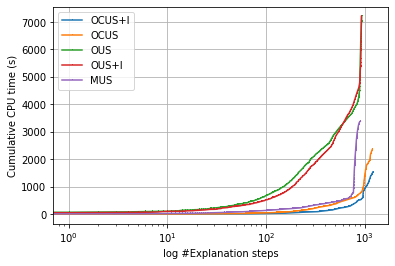

In [59]:
cactusGrouped2(dfAllConfigs, fact='cumul-ous', groupKeys=["config"], filename="rq4_b")

In [60]:
# table with 